# Training Artifact Classification Model

In [1]:
import os
import numpy as np
import pandas as pd
import keras
import cv2
from matplotlib import pyplot as plt
%matplotlib inline
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from sklearn.metrics import roc_curve,auc

from utils.resnet import DataGenerator, build_ResNet

## Prepare datasets

In [2]:
traindir_name = './data/artifact_classifier/train/'
testdir_name = './data/artifact_classifier/test/'

In [3]:
width = 576
height = 576

label_to_class = {
    'clean':0,
    'artifact':1
}

class_to_label = {v: k for k, v in label_to_class.items()}

train_params = {'dim': (width,height),
          'batch_size': 12,
          'n_classes': len(label_to_class),
          'n_channels': 3,
          'shuffle': True,
          'Augment': True,
           'PATH': traindir_name}

val_params = {'dim': (width,height),
          'batch_size': 12,
          'n_classes': len(label_to_class),
          'n_channels': 3,
          'shuffle': False,
          'Augment':False,
          'PATH': traindir_name}

test_params = {'dim': (width,height),
          'batch_size': 1,
          'n_classes': len(label_to_class),
          'n_channels': 3,
          'shuffle': False,
          'Augment':False,
          'PATH':testdir_name}

In [4]:
train_Images = []
train_Classes = []

for label_name in os.listdir(traindir_name):
    cls = label_to_class[label_name]
    for img_name in os.listdir('/'.join([traindir_name, label_name])):
        train_Images.append(label_name + '/' + img_name)
        train_Classes.append(cls)
train_Classes =  np.array(train_Classes, dtype=np.float32)
train_Images =  np.array(train_Images)

In [5]:
test_Images = []
test_Classes = []

for label_name in os.listdir(testdir_name):
    cls = label_to_class[label_name]
    for img_name in os.listdir('/'.join([testdir_name, label_name])):
        test_Images.append(label_name + '/' + img_name)
        test_Classes.append(cls)
test_Classes =  np.array(test_Classes, dtype=np.float32)
test_Images =  np.array(test_Images)

In [6]:
indices_train, indices_val = train_test_split(list(range(len(train_Images))), train_size=0.8, test_size=0.2, shuffle=True)
labels_train = train_Classes[indices_train]
labels_val = train_Classes[indices_val]
labels_test=test_Classes

partition={'train':train_Images[indices_train], 'validation':train_Images[indices_val], 'test':test_Images}

training_generator = DataGenerator(partition['train'], labels_train,**train_params)
validation_generator = DataGenerator(partition['validation'],labels_val, **val_params)
testing_generator = DataGenerator(partition['test'], labels_test,**test_params)

del train_Classes#, test_Classes
del train_Images#, test_Images

## Compile and train ResNet model

In [ ]:
epochs = 150
name = 'artifact_classifier_test'
chkpt = f'./weights/{name}_weights.h5'

cp_cb = ModelCheckpoint(filepath = chkpt, monitor='val_loss', verbose=1, save_best_only=True, save_weights_only=True, mode='auto')
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.1,patience=10, min_lr=0)
es_cb = EarlyStopping(monitor='val_loss', patience=25, verbose=1, mode='auto')

model = build_ResNet()

history = model.fit(training_generator, epochs=epochs,
                    validation_data=validation_generator,
                    callbacks=[cp_cb,reduce_lr,es_cb],
                    class_weight={0: 1.0, 1: 1.0},
                    shuffle=True)

Epoch 1/150
108/108 [==============================] - ETA: 0s - loss: 0.6871 - accuracy: 0.6921
Epoch 1: val_loss improved from inf to 11.29950, saving model to ./weights\artifact_classifier_test_weights.h5
108/108 [==============================] - 67s 573ms/step - loss: 0.6871 - accuracy: 0.6921 - val_loss: 11.2995 - val_accuracy: 0.6451 - lr: 0.0020
Epoch 2/150
108/108 [==============================] - ETA: 0s - loss: 0.4311 - accuracy: 0.7716
Epoch 2: val_loss improved from 11.29950 to 0.87214, saving model to ./weights\artifact_classifier_test_weights.h5
108/108 [==============================] - 64s 594ms/step - loss: 0.4311 - accuracy: 0.7716 - val_loss: 0.8721 - val_accuracy: 0.3086 - lr: 0.0020
Epoch 3/150
108/108 [==============================] - ETA: 0s - loss: 0.3382 - accuracy: 0.8565
Epoch 3: val_loss did not improve from 0.87214
108/108 [==============================] - 64s 591ms/step - loss: 0.3382 - accuracy: 0.8565 - val_loss: 5.6453 - val_accuracy: 0.6636 - lr: 0

### Visualise training

In [ ]:
df = pd.DataFrame(history.history)
df.plot(figsize=(8,5),ylim=(0,1.05))
plt.savefig(f'./results/{name}_training.png')
plt.show()

## Model Evaluation

In [ ]:
results = model.evaluate(testing_generator)
print("test loss, test acc:", results)

In [ ]:
# Breakdown of performance
pred = model.predict(testing_generator)
y_pred_bool = (pred>0.5).astype('int32')
y_test = keras.utils.to_categorical(labels_test, num_classes=2)

print(classification_report(y_test, y_pred_bool))

### Visualise ROC curve

In [ ]:
fpr_keras, tpr_keras, thresholds_keras = roc_curve(y_test.ravel(), pred.ravel())
auc_keras = auc(fpr_keras, tpr_keras)

In [ ]:
plt.figure(1)
plt.plot(fpr_keras, tpr_keras, label='ROC (AUC = {:.3f})'.format(auc_keras), c='orange', alpha=0.8)
sns.scatterplot(x=fpr_keras, y=tpr_keras, alpha=1, color='orange', s=15,edgecolor="none")
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.plot([0, 1], [0, 1], 'k--', c= 'gray')
plt.title('ROC curve')
plt.legend(loc='best')
plt.gca().spines[['top', 'right']].set_visible(False)
plt.savefig('./results/{name}_ROC.png', dpi=300, transparent=True,bbox_inches='tight')
plt.show()

### Explore any samples that were misclassified

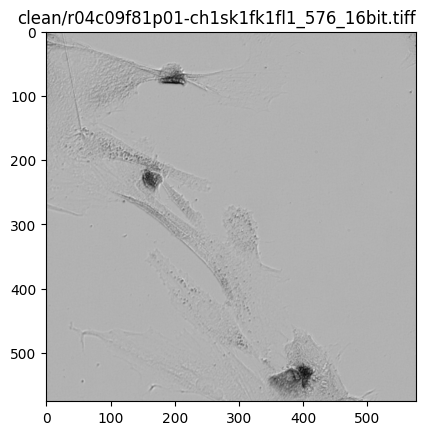

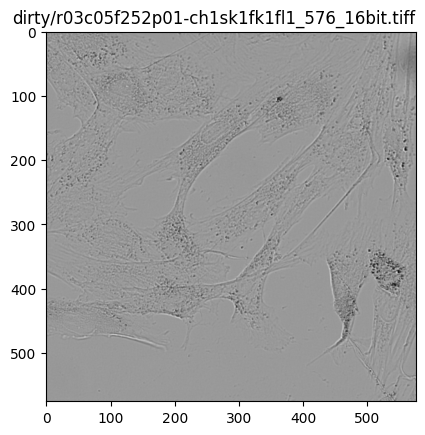

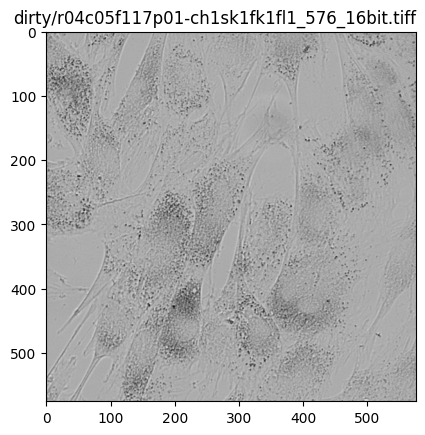

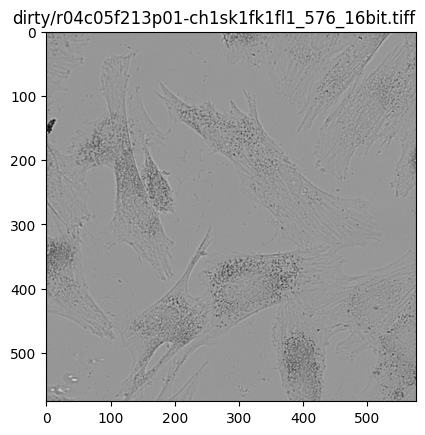

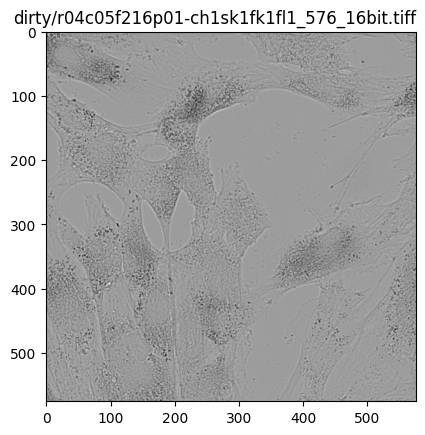

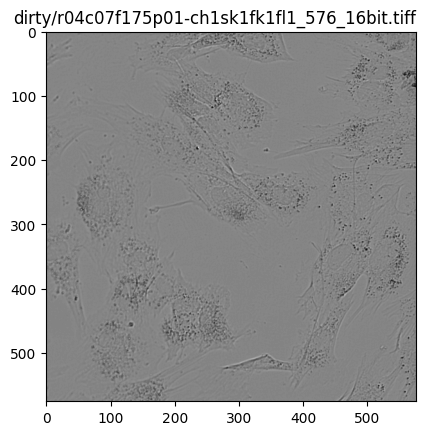

In [36]:
indices = [i for i in range(len(y_test)) if (y_test[i]!=y_pred_bool[i]).all()]

for image in test_Images[indices]:
    plt.figure()
    img = cv2.imread(os.path.join(testdir_name,image), -1)
    plt.title(image, loc = "right")
    plt.imshow(img, cmap='gray')

In [ ]:
import math
import os
import cv2
import matplotlib.pyplot as plt

n_plots = len(indices) # (or however many you programatically figure out you need)
n_cols = 4
n_rows = (n_plots + 1) // n_cols


imgs = [] #create an empty list called v_slice
for image in test_Images[indices]:
    img = cv2.imread(os.path.join(testdir_name,image), -1) #Here I load the same image 4 times-replace this  with code that generates images
    imgs.append(img)

_, axs = plt.subplots(n_row, n_col, figsize=(12, 12))
axs = axs.flatten()
for img, ax in zip(imgs, axs):
    ax.imshow(img, cmap='gray')
plt.show()

In [ ]:
n_plots = len(os.listdir(image_dir)) # (or however many you programatically figure out you need)
n_cols = 4
n_rows = math.ceil(n_plots/ n_cols)

plt.figure(figsize=(15, 30))
plt.subplots_adjust(hspace=0)

for n, image in enumerate(os.listdir(image_dir)):
    # add a new subplot iteratively
    ax = plt.subplot(n_rows, n_cols, n + 1)
    im = cv2.imread(os.path.join(image_dir,image), -1)
    ax.imshow(im, cmap='gray')

    ax.set_title(image)
    ax.xaxis.set_tick_params(labelbottom=False)
    ax.yaxis.set_tick_params(labelleft=False)

# Hide X and Y axes tick marks
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_xlabel("")

# Generate data subset for Score-CAM/UNET

In [13]:
import os
import shutil
import numpy as np
from utils.resnet import DataGenerator_Pred,build_ResNet

In [5]:
data_dir = 'D:/Chapter 5/Re-run/Artifact_Classifier/dirty/'

name = '576_16bit_081123-test_tiff_utilsdebug'

params = {'dim': (576,576),
          'batch_size': 1,
          'n_channels': 3,
          'shuffle': False,
          'PATH':data_dir}

In [6]:
images=np.array(os.listdir(data_dir))
partition={'data':images}
data_generator = DataGenerator_Pred(partition['data'], **params)

In [7]:
model = build_ResNet()
model.load_weights(f'./resnet_weight_{name}.h5') 

pred = model.predict(data_generator)
pred_bool = (pred>0.5).astype('int32')

1329/1329 [==============================] - 33s 23ms/step


In [9]:
dirty = []
clean = []
for im, pred_class in zip(images, pred_bool):
    if pred_class[1] == 1:
        dirty.append(im)
    else:
        clean.append(im)

        print(len(clean),len(dirty))

In [14]:
dest_path = 'D:/Chapter 5/Re-run/Artifact_Classifier/classified_dirty/'

if os.path.isdir(dest_path) == False:
        os.makedirs(dest_path)

for file in dirty:
    shutil.move(os.path.join(data_dir, file), dest_path)

In [37]:
#dest_path = 'D:/dataset/full_resnet/classed_clean/'

# filesToCopy = clean

# if os.path.isdir(dest_path) == False:
#         os.makedirs(dest_path)

# for file in clean:
#     shutil.move(os.path.join(data_dir, file), dest_path)